## Problem Description

The objective is to predict hourly bike rental demand. The target variable is "count", which is the total bikes
rented. The predictor variables are:

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

The data can be downloaded here: https://www.kaggle.com/c/bike-sharing-demand/data

I borrowed a few ideas from this excellent kaggle kernal:
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile 

147

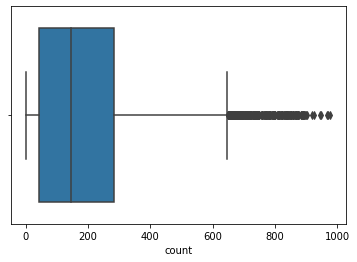

In [33]:
 # Import relevant Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from random import seed
from random import randrange
from sklearn.metrics import mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from math import sqrt
import math
import warnings
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load Data
os.chdir(r'C:\Users\Billy Hansen\Desktop\Kaggle Practice\Bike Demand')
df = pd.read_csv('train.csv')
toast = pd.read_csv('test.csv')
# Make Copy of Test Data
test = toast.copy()

# # EDA

# Check for missing Values
df.isnull().sum()

# Peak at data
df.head(10)

# Look at target variable
sb.boxplot('count', data=df);

# How many outliers?
len(df) - len(df[(np.abs(stats.zscore(df['count'])) < 3)])

Will keep outliers for now,
and try running both ways. Let's look at how the categorical variables, and see their relationship to the target
variable.

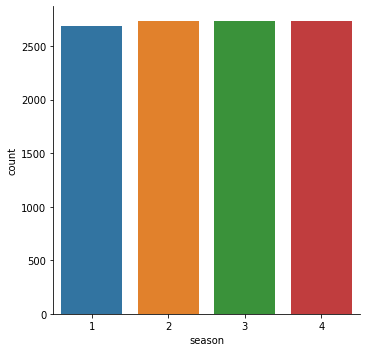

In [34]:
# Season Variable
sb.catplot('season', data=df, kind='count');

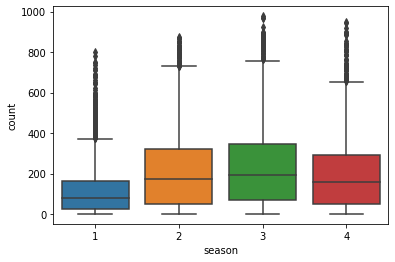

In [35]:
sb.boxplot(x = 'season', y='count', data=df);

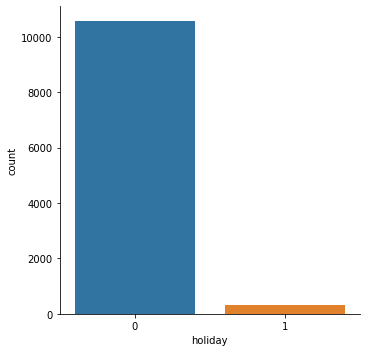

In [36]:
# Holiday 
sb.catplot('holiday', data=df, kind='count');

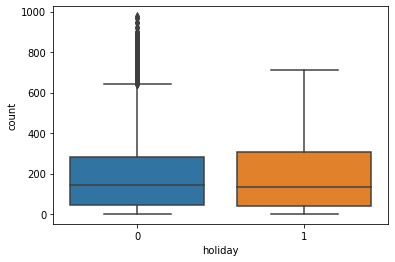

In [37]:
sb.boxplot(x='holiday', y='count', data=df);

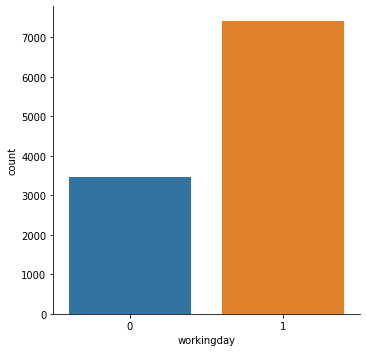

In [38]:
# Working Day
sb.catplot('workingday', data=df, kind='count');

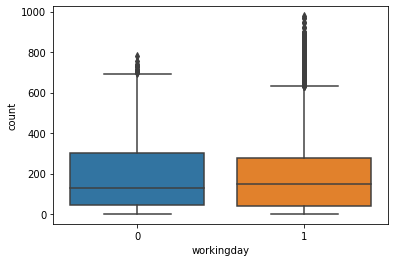

In [39]:
sb.boxplot(x='workingday', y='count', data=df);

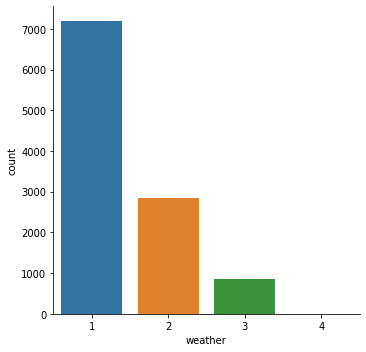

In [40]:
# Weather
sb.catplot('weather', data=df, kind='count');

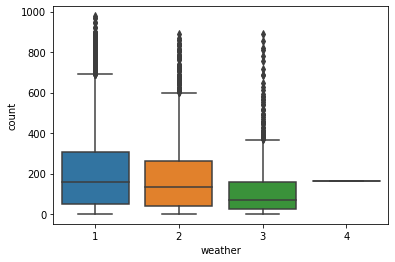

In [41]:
sb.boxplot(x='weather', y='count', data=df);

In [42]:
# Summary Stats
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


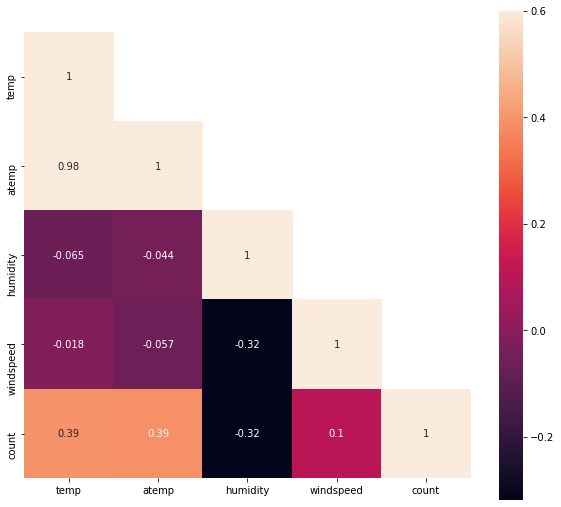

In [43]:
# Let's look at a coorelation matrix for all of our numeric variables
corr = df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(10, 9)
sb.heatmap(corr, mask=mask, vmax=.6, square=True, annot=True);

The number of rented bikes is
positively correlated with temperature, and negatively coorelated with huminity, which makes sense intuitively.
Atemp and temp are almost perfectly coorelated, so we should drop one of these variables to avoid
multi-colinearity. I'll drop "feel like temperature", and keep actual temperature. I'll perform all data prep to
both the train and test data sets.

In [44]:
# Drop atemp
df = df.drop(columns=['atemp'])
test = test.drop(columns=['atemp'])

# Change categorical variable types to objects
df['season'] = df['season'].astype('object')
df['holiday'] = df['holiday'].astype('object')
df['workingday'] = df['workingday'].astype('object')
df['weather'] = df['weather'].astype('object')
test['season'] = test['season'].astype('object')
test['holiday'] = test['holiday'].astype('object')
test['workingday'] = test['workingday'].astype('object')
test['weather'] = test['weather'].astype('object')

# We can engineer date variable to potentially have some predictive value. We should create hour, weekday, and month values to use in our models.

df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'].describe()


df['Hour'] = df['datetime'].dt.hour
df['Day'] = df['datetime'].dt.weekday
df['Month'] = df['datetime'].dt.month
df['Year'] = df['datetime'].dt.year

Let's look at how these new variables are related to our target

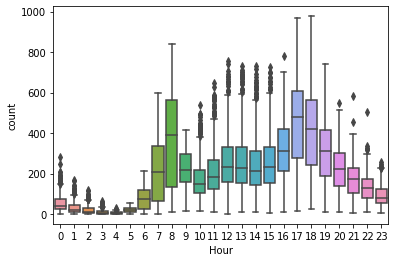

In [45]:
hours = pd.DataFrame(df.groupby(['Hour'])['count'].mean())
days = pd.DataFrame(df.groupby(['Day'])['count'].mean())
months = pd.DataFrame(df.groupby(['Month'])['count'].mean())


# Mean rentals for each hour of the day



sb.boxplot(x = 'Hour', y = 'count', data = df);

Hours looks like it will be an important variable

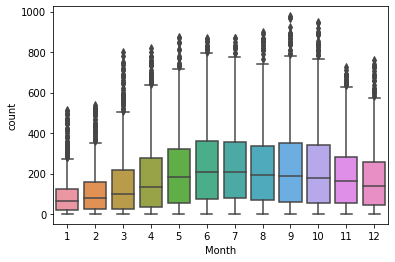

In [46]:
# Mean rentals each month
sb.boxplot(x='Month', y='count', data=df);

The summer months seem to be the most popular.

In [47]:
# Mean Rentals each day of the week
test['datetime'] = pd.to_datetime(test['datetime'])
test['datetime'].describe()

count                    6493
unique                   6493
top       2011-09-21 10:00:00
freq                        1
first     2011-01-20 00:00:00
last      2012-12-31 23:00:00
Name: datetime, dtype: object

C:\Users\Billy Hansen\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,Day,Hour,Month,Year,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,5,0,1,2011,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,5,1,1,2011,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,5,2,1,2011,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,5,3,1,2011,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,5,4,1,2011,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


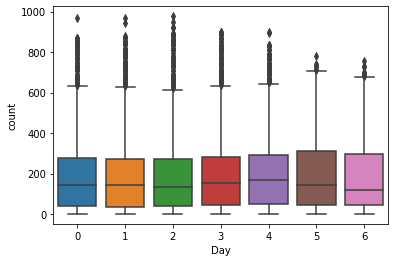

In [48]:
test['Hour'] = test['datetime'].dt.hour
test['Day'] = test['datetime'].dt.weekday
test['Month'] = test['datetime'].dt.month
test['Year'] = test['datetime'].dt.year


sb.boxplot(x='Day', y='count', data=df);


# # Day doesnt look like a very good variable, so we'll drop it.
# df = df.drop(columns = ['Day'])
# test = test.drop(columns = ['Day'])


# Change Data Types
df['Hour'] = df['Hour'].astype('object')
df['Month'] = df['Month'].astype('object')
df['Day'] = df['Day'].astype('object')
df['Year'] = df['Year'].astype('object')
test['Hour'] = test['Hour'].astype('object')
test['Month'] = test['Month'].astype('object')
test['Day'] = test['Day'].astype('object')
test['Year'] = test['Year'].astype('object')


# Join data frames together

data = df.append(test)


data.head()

There are many values with 0 as the wind speed. I suspect that these are not really 0s, but rather incomplete data. We'll fill these 0s with a random forest model.

In [49]:
# Grab data with 0 as wind speed
zerowind = data[data['windspeed'] ==0]
wind = data[data['windspeed']!=0]

# Simple random forest
rf_wind = RandomForestRegressor()
# Select models for training
windy = wind[["season","weather","humidity","Day","temp","Hour", 'Month']]
# fit data
rf_wind.fit(windy, wind['windspeed'])

# Make predictions
zerowindy = zerowind[["season","weather","humidity","Day","temp","Hour", 'Month']]
wind_values = rf_wind.predict(zerowindy)
zerowind['windspeed'] = wind_values

# Append data back together
data = wind.append(zerowind)


# Restore Data Types
cat_feets = ["season","holiday","workingday","weather","Day","Month","Year","Hour"]
num_feets = ["temp","humidity","windspeed"]
drop_feets = ['casual',"count","datetime","registered"]

for var in cat_feets:
    data[var] = data[var].astype("category")


# Get dummy variables
data = pd.get_dummies(data, columns = ["season","holiday","workingday","weather","Day","Month","Year","Hour"])


data.head()


# Break data back into train and test
df = data[pd.notnull(data['count'])].sort_values(by= ['datetime'])
test = data[~pd.notnull(data['count'])].sort_values(by = ['datetime'])
y = df['count']
df  = df.drop(drop_feets,axis=1)
test  = test.drop(drop_feets,axis=1)
X = df.copy()

C:\Users\Billy Hansen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We'll create seperate data sets that are normalized for models that benefit from normalization.

In [50]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
test_scaled = sc.transform(test)

C:\Users\Billy Hansen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Billy Hansen\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Billy Hansen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Now let's split data into training and testing sets, for scaled and unscaled data.

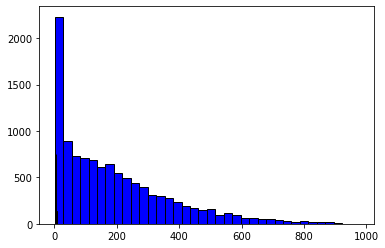

In [51]:
X_train_sc, X_test_sc, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 37)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 37)


# Let's plot the target variable and look at the distribution

plt.hist(y, color = 'blue', edgecolor = 'black',
         bins = int(180/5));


# Now let's look at a plot when we transform the vector using the np.log1p function

plt.hist(np.log1p(y), color = 'green', edgecolor = 'black',
         bins = int(180/5));


The second distribtion looks like it might help the model be more skillful. So we'l transform the target vector before we train the model

The Kaggle competition is scored with Root Mean Squared Logrithmic Error. We'll build a function that uses this method to score our results.

In [52]:
def rmsle(y, y1):
    log1 = np.nan_to_num(np.array([np.log1p(v) for v in y]))
    log2 = np.nan_to_num(np.array([np.log1p(v) for v in y1]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Now we'll transform our target variables

In [13]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize linear regression model
lin_model = LinearRegression()

# Train the model
lin_model.fit(X = X_train_sc,y = y_train)

# Make predictions
preds = lin_model.predict(X=X_test_sc)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(y_test),np.exp(preds)))

RMSLE Value For Linear Regression:  0.5474006735696768


Let's try a neural net.

In [14]:
from keras.callbacks import EarlyStopping
# ANN
model = Sequential()
model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

es = EarlyStopping(monitor='loss', mode='min', patience = 3, restore_best_weights = True, verbose=1)
model.fit(X_train_sc, y_train, epochs=100, batch_size=5, callbacks = [es])

# Make predictions
preds = model.predict(X_test_sc)
print ("RMSLE Value For ANN: ",rmsle(np.exp(y_test),np.exp(preds)))

Epoch 1/100
8708/8708 [==============================] - 2s 203us/step - loss: 0.0985
Epoch 2/100
8708/8708 [==============================] - 1s 155us/step - loss: 0.0078
Epoch 3/100
8708/8708 [==============================] - 1s 153us/step - loss: 0.0070
Epoch 4/100
8708/8708 [==============================] - 1s 154us/step - loss: 0.0066
Epoch 5/100
8708/8708 [==============================] - 1s 154us/step - loss: 0.0065
Epoch 6/100
8708/8708 [==============================] - 1s 163us/step - loss: 0.0060
Epoch 7/100
8708/8708 [==============================] - 1s 164us/step - loss: 0.0059
Epoch 8/100
8708/8708 [==============================] - 1s 157us/step - loss: 0.0056
Epoch 9/100
8708/8708 [==============================] - 1s 158us/step - loss: 0.0054
Epoch 10/100
8708/8708 [==============================] - 1s 157us/step - loss: 0.0052
Epoch 11/100
8708/8708 [==============================] - 1s 157us/step - loss: 0.0051
Epoch 12/100
8708/8708 [============================

Now Ridge Regression with grid search for the optimal alpha

In [15]:
ridgey = Ridge()
params = {'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}

# Make scorer using rmsle
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_ridge = GridSearchCV( ridgey,
                          params,
                          scoring = rmsle_scorer,
                          cv=5)

grid_ridge.fit(X_train_sc, y_train)


preds = grid_ridge.predict(X= X_test_sc)
print (grid_ridge.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(y_test),np.exp(preds)))

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.5471747718807011


Let's try random forest. We'll used unscaled data for tree based models

In [16]:
# Initialize
rf_mod = RandomForestRegressor(n_estimators = 300)
# Train
rf_mod.fit(X_train, y_train)
# Make Predictions
preds = rf_mod.predict(X_test)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_test),np.exp(preds)))

RMSLE Value For Random Forest:  0.30167642848909115


Wooooooo!!!! Let's try a gradient boosting model

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)


gbm.fit(X_train, y_train)
preds = gbm.predict(X_test)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(y_test),np.exp(preds)))

RMSLE Value For Gradient Boost:  0.28965377932732644


Splendid

In [18]:
gbm = GradientBoostingRegressor()
params = {'n_estimators': [4000], 'alpha': [0.1, .05, .15]}

# Make scorer using rmsle
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_gbm = GridSearchCV( gbm,
                          params,
                          scoring = rmsle_scorer,
                          cv=3)

grid_gbm.fit(X_train, y_train)

preds = grid_gbm.predict(X= X_test)
print (grid_gbm.best_params_)
print ("RMSLE Value For Gradient Bossing Regressor is: ",rmsle(np.exp(y_test),np.exp(preds)))


yy = np.log1p(y)

gbm = GradientBoostingRegressor(n_estimators = 4000, alpha = .05)
gbm.fit(X, yy)

predsTest = gbm.predict(X=test)

# Make submission, transforming predictions back to appropriate scale
submission = pd.DataFrame({
        "datetime": toast['datetime'],
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('hoot4.csv', index=False)

{'alpha': 0.1, 'n_estimators': 4000}
RMSLE Value For Gradient Bossing Regressor is:  0.2893495052383549


This submission scored approx .39 on kaggle, which is in the top 6th percentile of all submissions.